## **Mengimport module**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.feature_selection import RFECV

import xgboost as xgb
from xgboost import cv, DMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score

## **Membaca Data**

In [2]:
data = pd.read_csv("../Data/stroke_data.csv")
data.head()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,0,1,1,4,1,228.69,36.6,1,1
1,1.0,42.0,0,1,1,4,0,105.92,32.5,0,1
2,0.0,61.0,0,0,1,4,1,171.23,34.4,1,1
3,1.0,41.0,1,0,1,3,0,174.12,24.0,0,1
4,1.0,85.0,0,0,1,4,1,186.21,29.0,1,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40910 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40907 non-null  float64
 1   age                40910 non-null  float64
 2   hypertension       40910 non-null  int64  
 3   heart_disease      40910 non-null  int64  
 4   ever_married       40910 non-null  int64  
 5   work_type          40910 non-null  int64  
 6   Residence_type     40910 non-null  int64  
 7   avg_glucose_level  40910 non-null  float64
 8   bmi                40910 non-null  float64
 9   smoking_status     40910 non-null  int64  
 10  stroke             40910 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.4 MB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,40907.0,0.555162,0.496954,0.00,0.00,1.00,1.00,1.00
age,40910.0,51.327255,21.623969,-9.00,35.00,52.00,68.00,103.00
hypertension,40910.0,0.213835,0.410017,0.00,0.00,0.00,0.00,1.00
heart_disease,40910.0,0.127719,0.333781,0.00,0.00,0.00,0.00,1.00
ever_married,40910.0,0.821340,0.383072,0.00,1.00,1.00,1.00,1.00
work_type,40910.0,3.461134,0.780919,0.00,3.00,4.00,4.00,4.00
Residence_type,40910.0,0.514886,0.499784,0.00,0.00,1.00,1.00,1.00
avg_glucose_level,40910.0,122.075901,57.561531,55.12,78.75,97.92,167.59,271.74
bmi,40910.0,30.406355,6.835072,11.50,25.90,29.40,34.10,92.00
smoking_status,40910.0,0.488609,0.499876,0.00,0.00,0.00,1.00,1.00


In [5]:
##Mengecek nilai kosong (missing value)
data.isna().sum()

sex                  3
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [6]:
data = data.dropna()
data.isna().sum()

sex                  0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
##Mengubah tipe kolom
categorical_columns = ['sex', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']
data[categorical_columns] = data[categorical_columns].astype('category')

In [8]:
##Menyeleksi variabel (feature selection)
X = data.drop(["stroke"], axis = 1)
y = data["stroke"]

estimator = DecisionTreeClassifier(max_depth=5,min_samples_split=100)
rfecv = RFECV(estimator=estimator, cv=StratifiedKFold(10, random_state=42, shuffle=True), scoring="accuracy")
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
      estimator=DecisionTreeClassifier(max_depth=5, min_samples_split=100),
      scoring='accuracy')

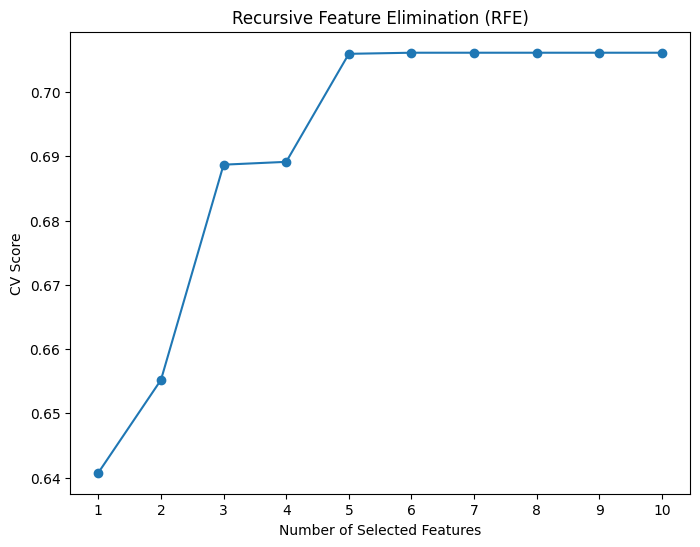

The optimal number of features: 6


In [9]:
##Plot RFE
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.xticks(range(1, X.shape[1] + 1))
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("The optimal number of features: {}".format(rfecv.n_features_))

In [10]:
X = data.drop(['stroke'], axis = 1)
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [11]:
##Prediktor terpilih
selected_features = X.columns[rfecv.support_]
X_selected = X[selected_features]

In [12]:
data['stroke'].value_counts()

stroke
1    20460
0    20447
Name: count, dtype: int64

In [13]:
##Membagi data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
X_train.head()

,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi
20414,0,0,1,4,219.72,33.7
35198,0,0,0,3,81.54,31.8
1780,1,0,1,3,72.67,28.9
30867,0,0,1,4,97.89,38.7
1864,0,0,1,4,80.13,23.4


In [15]:
y_train.head()

20414    1
35198    0
1780     1
30867    0
1864     1
Name: stroke, dtype: category
Categories (2, int64): [0, 1]

In [16]:
##Mengatasi imbalance data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [17]:
y_train.value_counts()

stroke
0    16368
1    16368
Name: count, dtype: int64

In [18]:
##Menstandarisasi data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Melakukan Klasifikasi**

In [19]:
xg = xgb.XGBClassifier(n_estimators=350)
xg.fit(X_train, y_train)
xg_preds = xg.predict(X_test)
print(classification_report(y_test, xg_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4090
           1       1.00      1.00      1.00      4092

    accuracy                           1.00      8182
   macro avg       1.00      1.00      1.00      8182
weighted avg       1.00      1.00      1.00      8182



## **XGBoost dan Cross Validation**

In [20]:
# Inisialisasi data dan parameter
params = {
    "objective": "binary:logistic",
    "colsample_bytree": 0.3,
    "learning_rate": 0.1,
    "max_depth": 10,
    "alpha": 10,
}
data_dmatrix = DMatrix(data=X_train, label=y_train)  # Ganti X_train dan y_train sesuai data Anda

# List untuk menyimpan hasil dari masing-masing nfold
nfolds = [3, 5, 10]
best_results = {}

for n in nfolds:
    # Menjalankan cross-validation untuk setiap nilai nfold
    xgb_cv = cv(
        dtrain=data_dmatrix,
        params=params,
        nfold=n,
        num_boost_round=50,  # Jumlah iterasi yang digunakan selama cross-validation
        early_stopping_rounds=10,
        metrics="auc",
        as_pandas=True,
        seed=42,
    )
    
    # Menyimpan iterasi terbaik berdasarkan AUC
    best_iteration = xgb_cv['test-auc-mean'].idxmax()
    best_auc = xgb_cv['test-auc-mean'].iloc[best_iteration]
    # Tidak perlu menambahkan n_estimators dalam params, gunakan num_boost_round
    best_num_boost_round = best_iteration  # Gunakan jumlah iterasi terbaik
    
    # Membuat model dengan jumlah estimators terbaik
    model = xgb.XGBClassifier(**params, n_estimators=best_num_boost_round)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Menghitung recall pada data uji
    recall = recall_score(y_test, y_pred)
    best_results[n] = {
        'best_iteration': best_iteration,
        'recall': recall,
        'xgb_cv': xgb_cv
    }
    
    print(f"nfold = {n}")
    print(f"Best Recall: {recall} at iteration {best_iteration}")
    
    # Menampilkan classification report untuk nfold ini
    print(f"Classification report for nfold = {n}:")
    print(classification_report(y_test, y_pred))
    print("="*50)

# Menentukan nfold dengan recall terbaik
best_nfold = max(best_results, key=lambda x: best_results[x]['recall'])
print(f"nfold terbaik berdasarkan Recall adalah: {best_nfold} dengan Recall {best_results[best_nfold]['recall']}")

nfold = 3
Best Recall: 0.7612414467253177 at iteration 8
Classification report for nfold = 3:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      4090
           1       0.82      0.76      0.79      4092

    accuracy                           0.79      8182
   macro avg       0.80      0.79      0.79      8182
weighted avg       0.80      0.79      0.79      8182

nfold = 5
Best Recall: 0.8404203323558163 at iteration 49
Classification report for nfold = 5:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4090
           1       0.84      0.84      0.84      4092

    accuracy                           0.84      8182
   macro avg       0.84      0.84      0.84      8182
weighted avg       0.84      0.84      0.84      8182

nfold = 10
Best Recall: 0.8443304007820137 at iteration 47
Classification report for nfold = 10:
              precision    recall  f1-score   support

     

## **Membuat Confussion Matrix**

In [21]:
# Membuat model terbaik berdasarkan nfold terbaik dan iterasi terbaik
best_iteration = best_results[best_nfold]['best_iteration']
params['n_estimators'] = best_iteration  # Set n_estimators ke iterasi terbaik

In [22]:
# Latih model dengan data pelatihan
model_best = xgb.XGBClassifier(**params)
model_best.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=47, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, ...)

In [23]:
# Prediksi data uji
y_pred_best = model_best.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      4090
           1       0.84      0.84      0.84      4092

    accuracy                           0.84      8182
   macro avg       0.84      0.84      0.84      8182
weighted avg       0.84      0.84      0.84      8182



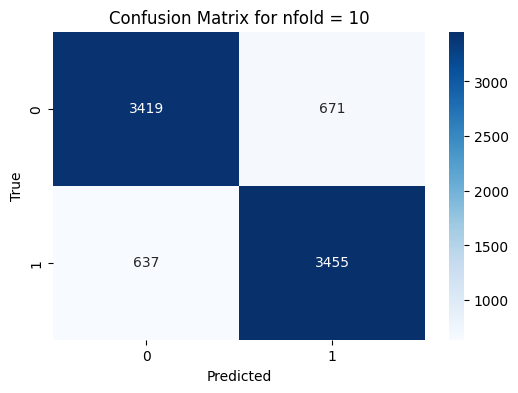

In [25]:
# Menghitung dan menampilkan confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Visualisasi confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for nfold = {best_nfold}')
plt.show()

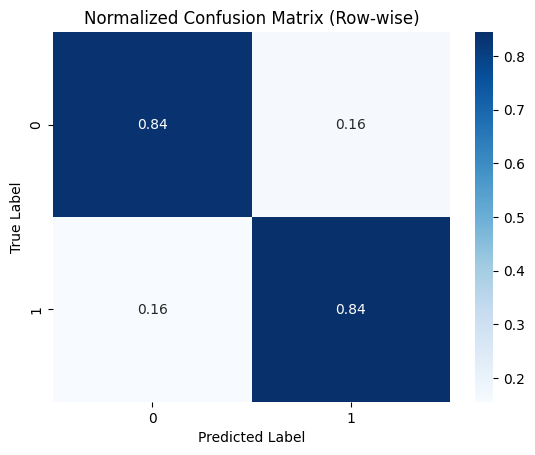

In [26]:
##Membuat confussion matrix yang dinormalisasi
def normalize_confusion_matrix(cm, norm='true'):
    if norm == 'true':
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif norm == 'pred':
        cm_normalized = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
    elif norm == 'all':
        cm_normalized = cm.astype('float') / cm.sum()
    else:
        raise ValueError("Unknown normalization type. Use 'true', 'pred', or 'all'.")
    
    return cm_normalized

cm = confusion_matrix(y_test, y_pred_best)
cm_normalized = normalize_confusion_matrix(cm, norm='true')

# Plotting
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Confusion Matrix (Row-wise)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **Menyimpan Model**

In [27]:
import joblib
import os

# Tentukan path folder spesifik
folder_path = "./Output_Model"
os.makedirs(folder_path, exist_ok=True)  # Buat folder jika belum ada

# Simpan model XGBoost ke folder spesifik
joblib.dump(xg, os.path.join(folder_path, 'xgboost_st.pkl'))

['./Output_Model\\xgboost_st.pkl']